In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.adapt import MLkNN
from sklearn.metrics import hamming_loss, accuracy_score
import string 

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier

from nltk.tokenize import word_tokenize



1) Split the full dataset into 0.9 train, 0.1 validation. 0.1 validation is all labelled. <br>
2) The 0.9 train is split into 0.2 labelled, 0.8 unlabelled data. <br>
3) Create a vectorizer (I am using tf-idf) for x value of labeled train, test and unlabeled training datasets<br>
4) Build model from labelled train and label the unlabeled training datasets. Measure for F1 scores. <br>
5) As multilabel/multiclass will output multiple probabilities, only models that have a result higher than the threshold can be accepted. <br>
6) Concatting train labeled data with prediction of unlabeled that have probability > 0.74 (threshold based on journal). This new pseudo-labelled data will be added to the train labelled data, and a second model (will keep to the same classifier) will be run from the new train data sets. <br>
7)Use the second model to predict the remaining of unlabeled data, then iterate step 3 until there are no probability of predicted pseudo-labelled>0.74


In [2]:
#this 0.2/0.8 split is not a hard criteria


In [3]:
df_train_labelled = pd.read_csv('train_labelled_sample.csv')
df_validation_labelled = pd.read_csv('validation_labelled_sample.csv')
df_test_sample = pd.read_csv('df_test_sample.csv')

In [4]:
df_train_labelled

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,518d1baa4ee62c06,"""@Josh3580 of course you are going to oppose i...",0,0,0,0,0,0
1,4682125b685509da,"Copyright Violations\nZhangshou: By now, you ...",0,0,0,0,0,0
2,573c6e9dd5614ade,"Edit request from 120.63.15.134, 29 August 201...",0,0,0,0,0,0
3,7470c1caba22935e,"""I'm around again... Thanks for the comments M...",0,0,0,0,0,0
4,8a24aab08fd0abef,", as you did at Meagan Good, you may be blocke...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
995,1add881f75c8b51b,"Looks like instead of black choppers, your see...",0,0,0,0,0,0
996,9a3ad8998d4ce52b,"""\n\n BLACK DAHLIA MURDER IS NOT 'MELODIC DEAT...",1,0,1,0,1,0
997,f861da2322f1f9db,"""\n\n Rugby \n\nHey, I saw your contribution t...",0,0,0,0,0,0
998,9bfb9305ea9c4293,"Not that it matters, because thanks to Moriori...",0,0,0,0,0,0


In [5]:
df_test_sample

,id,comment_text
0,2d8fbd7002d1bbde,Thank you for experimenting with the page Drif...
1,5c547ec9e6d8e14d,:: You have added no useful information to Per...
2,1d372ff0a1da78a4,"*Oppose - Romanisation requires FK, not FC."
3,ac5e86d8efdc7b94,":Cutter, Wisconsin-thank you-"
4,0ae9990eed171c6a,== Armillaria root rot == \n\n I figured I sho...
...,...,...
3995,2080b2eb59ecfe3d,""" \n\n == Pheonix V. == \n\n You're welcome. I..."
3996,5b4d04460d5b8773,== Insertion of penis into a pig's mouth == \n...
3997,56495fd916ec5a89,""" \n\n == The history?! == \n\n Who wrote that..."
3998,7ca8e71434a0c6b6,==Categories for discussion nomination of Cate...


In [6]:
df_validation_labelled

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1ffccb4076cbbac7,"""\n\n You have no idea... \n\n...how honored I...",0,0,0,0,0,0
1,a36cc13a4c351525,"By definition, there is no paraphiliac flirting.",0,0,0,0,0,0
2,3321525528be3a31,"""\n\nBelow I am pasting an email from a histor...",0,0,0,0,0,0
3,4a98b516f7cef0e7,I note that you avoid answering the question c...,0,0,0,0,0,0
4,0639c3b95fa665c7,Private request for admin intervention ) \n\nH...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
995,43893ddfd1beca02,I'm not one of your students. Talk to me like ...,1,0,0,0,0,0
996,9f803165f5c43ef9,"""\nCall it """"Neighborhoods"""" and have it as a ...",0,0,0,0,0,0
997,472d7fc518ef1742,"""\nI try to never block for warring if protect...",0,0,0,0,0,0
998,ecb592c762bcfda3,"""\n\n Translating \n\nHi. I don't think there ...",0,0,0,0,0,0


# Binary classifier 

In [7]:
def training_model(X_train,y_train,vectorizer): 
    pipeline = Pipeline([('vect', vectorizer),
                         ('chi',  SelectKBest(chi2, k=1200)),
                         ('clf', RandomForestClassifier())])
    model = pipeline.fit(X_train, y_train) #only used in the trained data
    return model


def cleaning_data(part_df):
    words = stopwords.words("english")
    part_df['comment_text_cleaned']= part_df['comment_text'].apply(lambda x: word_tokenize(x))
    part_df['comment_text_cleaned']= part_df['comment_text_cleaned'].apply(lambda x: [i for i in x if i not in words])
    part_df['comment_text_cleaned']= part_df['comment_text_cleaned'].apply(lambda x: " ".join([i for i in x if i not in string.punctuation]))
    return part_df

def vectorized_data(part_df):
    vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
    #final_features = vectorizer.fit_transform(part_df['comment_text_cleaned']).toarray()
    return vectorizer

#sublinear_tfbool, default=False
#Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).


In [8]:
cleaned = cleaning_data(df_train_labelled)
#cleaned = cleaning_data(df_train.sample(20000))
cleaned_val = cleaning_data(df_validation_labelled)
#cleaned_val = cleaning_data(df_val.sample(5000))
# you have to clean also the comment_text in unlabelled data
cleaned_unlabelled = cleaning_data(df_test_sample)

In [9]:
vectorized = vectorized_data(cleaned)
X_train = cleaned['comment_text_cleaned']
y_train = cleaned['toxic']
X_val = cleaned_val['comment_text_cleaned']
y_val = cleaned_val['toxic']
vectorizer = vectorized

trained_model = training_model(X_train,y_train,vectorizer)

In [10]:
#total features
doneby = vectorizer.fit(X_train)
doneby.idf_.shape

(2292,)

In [11]:
y_train_pred=trained_model.predict(X_train)
precision_score(y_train,y_train_pred),recall_score(y_train,y_train_pred), roc_auc_score(y_train,y_train_pred)

(1.0, 0.9615384615384616, 0.9807692307692308)

In [12]:
y_val_pred=trained_model.predict(X_val)
precision_score(y_val,y_val_pred),recall_score(y_val,y_val_pred), roc_auc_score(y_val,y_val_pred)

(0.9230769230769231, 0.3564356435643564, 0.6765493012037577)

In [13]:
X_unlabelled = cleaned_unlabelled['comment_text_cleaned']
y_prob = trained_model.predict_proba(X_unlabelled)
y_prob[:,1]

array([0.07      , 0.49      , 0.27643387, ..., 0.05255694, 0.        ,
       0.20674923])

In [14]:
y_prob

array([[0.93      , 0.07      ],
       [0.51      , 0.49      ],
       [0.72356613, 0.27643387],
       ...,
       [0.94744306, 0.05255694],
       [1.        , 0.        ],
       [0.79325077, 0.20674923]])

In [15]:
#cleaned_unlabelled = cleaned_unlabelled.append(dict(zip(cleaned_unlabelled.columns, y_prob)), ignore_index=True)

In [16]:
cleaned_unlabelled['newcol'] = y_prob.tolist()

In [17]:
##https://stackoverflow.com/questions/35491274/split-a-pandas-column-of-lists-into-multiple-columns

In [18]:
extras_unlabelled = pd.DataFrame(cleaned_unlabelled['newcol'].to_list(), columns=['team1','team2'])

In [20]:
df_merged = pd.concat([cleaned_unlabelled, extras_unlabelled], axis=1, ignore_index=True, sort=False)

In [21]:
df_merged 

,0,1,2,3,4,5
0,2d8fbd7002d1bbde,Thank you for experimenting with the page Drif...,Thank experimenting page Drifting motorsport W...,"[0.93, 0.07]",0.930000,0.070000
1,5c547ec9e6d8e14d,:: You have added no useful information to Per...,You added useful information Peregrin Took 's ...,"[0.51, 0.49]",0.510000,0.490000
2,1d372ff0a1da78a4,"*Oppose - Romanisation requires FK, not FC.",Oppose Romanisation requires FK FC,"[0.7235661254847213, 0.27643387451527834]",0.723566,0.276434
3,ac5e86d8efdc7b94,":Cutter, Wisconsin-thank you-",Cutter Wisconsin-thank you-,"[0.9712925383440089, 0.028707461655991064]",0.971293,0.028707
4,0ae9990eed171c6a,== Armillaria root rot == \n\n I figured I sho...,== Armillaria root rot == I figured I point on...,"[0.8454497844384268, 0.15455021556157303]",0.845450,0.154550
...,...,...,...,...,...,...
3995,2080b2eb59ecfe3d,""" \n\n == Pheonix V. == \n\n You're welcome. I...",`` == Pheonix V. == You 're welcome I also blo...,"[0.937, 0.063]",0.937000,0.063000
3996,5b4d04460d5b8773,== Insertion of penis into a pig's mouth == \n...,== Insertion penis pig 's mouth == According C...,"[0.8048177357165947, 0.19518226428340504]",0.804818,0.195182
3997,56495fd916ec5a89,""" \n\n == The history?! == \n\n Who wrote that...",`` == The history == Who wrote crap something ...,"[0.9474430626562979, 0.052556937343702044]",0.947443,0.052557
3998,7ca8e71434a0c6b6,==Categories for discussion nomination of Cate...,==Categories discussion nomination Category Ea...,"[1.0, 0.0]",1.000000,0.000000


In [22]:
np.where(y_prob[:,1] > 0.74,1, -1) #this is either 1, or not (-1)
#https://stackoverflow.com/questions/28430904/set-numpy-array-elements-to-zero-if-they-are-above-a-specific-threshold

array([-1, -1, -1, ..., -1, -1, -1])

In [23]:
np.where(y_prob[:,0] > 0.74,0,-1)

array([ 0, -1, -1, ...,  0,  0,  0])

In [24]:
#assign column to unlabelled (propagate_toxic)
cleaned_unlabelled['propagate_toxic']=np.where(y_prob[:,1] > 0.85,1, -1)

In [25]:
cleaned_unlabelled['propagate_not_toxic']=np.where(y_prob[:,0] > 0.85,0,-1)

In [26]:
cleaned_unlabelled

,id,comment_text,comment_text_cleaned,newcol,propagate_toxic,propagate_not_toxic
0,2d8fbd7002d1bbde,Thank you for experimenting with the page Drif...,Thank experimenting page Drifting motorsport W...,"[0.93, 0.07]",-1,0
1,5c547ec9e6d8e14d,:: You have added no useful information to Per...,You added useful information Peregrin Took 's ...,"[0.51, 0.49]",-1,-1
2,1d372ff0a1da78a4,"*Oppose - Romanisation requires FK, not FC.",Oppose Romanisation requires FK FC,"[0.7235661254847213, 0.27643387451527834]",-1,-1
3,ac5e86d8efdc7b94,":Cutter, Wisconsin-thank you-",Cutter Wisconsin-thank you-,"[0.9712925383440089, 0.028707461655991064]",-1,0
4,0ae9990eed171c6a,== Armillaria root rot == \n\n I figured I sho...,== Armillaria root rot == I figured I point on...,"[0.8454497844384268, 0.15455021556157303]",-1,-1
...,...,...,...,...,...,...
3995,2080b2eb59ecfe3d,""" \n\n == Pheonix V. == \n\n You're welcome. I...",`` == Pheonix V. == You 're welcome I also blo...,"[0.937, 0.063]",-1,0
3996,5b4d04460d5b8773,== Insertion of penis into a pig's mouth == \n...,== Insertion penis pig 's mouth == According C...,"[0.8048177357165947, 0.19518226428340504]",-1,-1
3997,56495fd916ec5a89,""" \n\n == The history?! == \n\n Who wrote that...",`` == The history == Who wrote crap something ...,"[0.9474430626562979, 0.052556937343702044]",-1,0
3998,7ca8e71434a0c6b6,==Categories for discussion nomination of Cate...,==Categories discussion nomination Category Ea...,"[1.0, 0.0]",-1,0


In [27]:
cleaned_unlabelled['new_label'] = cleaned_unlabelled.apply(lambda x: np.max([x['propagate_toxic'], x['propagate_not_toxic']]), axis = 1)
cleaned_unlabelled[cleaned_unlabelled['new_label'] == 1].shape
#0 means not toxic for certain (>0.74)
#1 means toxic for certain (>0.74)
#-1 means cannot tell (<0.74)
#114 is fine because its binary

(66, 7)

In [28]:
psuedo_label_df = cleaned_unlabelled[cleaned_unlabelled['new_label'] > -1]
remaining_unlabelled_df = cleaned_unlabelled[cleaned_unlabelled['new_label'] == -1]

In [29]:
psuedo_label_df.rename(columns={'new_label':'toxic'}, inplace=True)
psuedo_label_df

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,id,comment_text,comment_text_cleaned,newcol,propagate_toxic,propagate_not_toxic,toxic
0,2d8fbd7002d1bbde,Thank you for experimenting with the page Drif...,Thank experimenting page Drifting motorsport W...,"[0.93, 0.07]",-1,0,0
3,ac5e86d8efdc7b94,":Cutter, Wisconsin-thank you-",Cutter Wisconsin-thank you-,"[0.9712925383440089, 0.028707461655991064]",-1,0,0
6,dd71652756a30a35,", 10 July 2015 (UTC) \n\n ::Cool. Thanks for ...",10 July 2015 UTC :Cool Thanks input 10:14,"[0.9947777777777778, 0.005222222222222222]",-1,0,0
8,d8ca6c21cebb8793,Please refrain from adding nonsense to Wikiped...,Please refrain adding nonsense Wikipedia Ameri...,"[0.9930887825624666, 0.0069112174375332265]",-1,0,0
10,6d722955591d95d8,"""==Doctored Photo on Front Page== \n Do you th...",`` ==Doctored Photo Front Page== Do think time...,"[0.9, 0.1]",-1,0,0
...,...,...,...,...,...,...,...
3988,268d1a0738ed7e35,Article needs an update,Article needs update,"[0.9913137254901961, 0.008686274509803922]",-1,0,0
3990,587633a5ffdb19fa,""" \n\n The Southern Kuriles are officially cla...",`` The Southern Kuriles officially claimed I r...,"[0.9636666666666668, 0.036333333333333336]",-1,0,0
3995,2080b2eb59ecfe3d,""" \n\n == Pheonix V. == \n\n You're welcome. I...",`` == Pheonix V. == You 're welcome I also blo...,"[0.937, 0.063]",-1,0,0
3997,56495fd916ec5a89,""" \n\n == The history?! == \n\n Who wrote that...",`` == The history == Who wrote crap something ...,"[0.9474430626562979, 0.052556937343702044]",-1,0,0


In [30]:
cleaned_unlabelled['new_label'] = cleaned_unlabelled.apply(lambda x: np.max([x['propagate_toxic'], x['propagate_not_toxic']]), axis = 1)
cleaned_unlabelled[cleaned_unlabelled['new_label'] == 1].shape

(66, 7)

In [31]:
#run this again 
vectorized = vectorized_data(cleaned)
X_train = cleaned['comment_text_cleaned']
y_train = cleaned['toxic']
vectorizer = vectorized
trained_model = training_model(X_train,y_train,vectorizer)

In [32]:
y_train_pred=trained_model.predict(X_train)
precision_score(y_train,y_train_pred),recall_score(y_train,y_train_pred), roc_auc_score(y_train,y_train_pred)

(1.0, 0.9615384615384616, 0.9807692307692308)

In [33]:
y_val_pred=trained_model.predict(X_val)
precision_score(y_val,y_val_pred),recall_score(y_val,y_val_pred), roc_auc_score(y_val,y_val_pred)

(0.9473684210526315, 0.3564356435643564, 0.6771054747298978)

In [34]:
# by increasing dataset, you give ML model more ability to generalise
#(0.8947368421052632, 0.38202247191011235, 0.6888158462733877)

## Refactoring code

In [35]:
#repeats process until no new labels can be added
def define_x_y(cleaned):
    X_train = cleaned['comment_text_cleaned']
    y_train = cleaned['toxic']
    return (X_train, y_train)

def training_process(cleaned):
    vectorized = vectorized_data(cleaned)
    vectorizer = vectorized
    X_train, y_train = define_x_y(cleaned)
    return training_model(X_train,y_train,vectorizer)

def train_val_scores(x, y_val, trained_model): 
    y_val_pred=trained_model.predict(x) #transform depending on which type of function you are talking about
    return precision_score(y_val,y_val_pred),recall_score(y_val,y_val_pred), roc_auc_score(y_val,y_val_pred)

def pseudo_label_creation(trained_model, cleaned_unlabelled):
    X_unlabelled = cleaned_unlabelled['comment_text_cleaned']
    y_prob = trained_model.predict_proba(X_unlabelled)
    cleaned_unlabelled['propagate_toxic']=np.where(y_prob[:,1] > 0.85,1, -1)
    cleaned_unlabelled['propagate_not_toxic']=np.where(y_prob[:,0] > 0.85,0,-1)
    cleaned_unlabelled['new_label'] = cleaned_unlabelled.apply(lambda x: np.max([x['propagate_toxic'], x['propagate_not_toxic']]), axis = 1)
    pseudo_label_df = cleaned_unlabelled[cleaned_unlabelled['new_label'] > -1]
    remaining_unlabelled_df = cleaned_unlabelled[cleaned_unlabelled['new_label'] == -1]
    pseudo_label_df.rename(columns={'new_label':'toxic'}, inplace=True)
    return pseudo_label_df, remaining_unlabelled_df

In [36]:
import warnings
warnings.filterwarnings("ignore")

size_new_labels = 51

cleaned = cleaning_data(df_train_labelled)
cleaned_val = cleaning_data(df_validation_labelled)
# you have to clean also the comment_text in unlabelled data
cleaned_unlabelled = cleaning_data(df_test_sample)

val_precision = []
val_recall = []
val_roc_auc_score = []
min_new_labels = 50
size_training = []
X_val, y_val = define_x_y(cleaned_val)

while size_new_labels > min_new_labels:
    print(len(cleaned))
    trained_model = training_process(cleaned)
    X_train,y_train = define_x_y(cleaned) 
    #print('train\nprecision, recall, roc_auc_score ')
    p,r,roc = train_val_scores(X_train,y_train, trained_model)
    #print('val\nprecision, recall, roc_auc_score ')
    p,r,roc = train_val_scores(X_val, y_val, trained_model)
    val_precision.append(p)
    val_recall.append(r)
    val_roc_auc_score.append(roc)  
    #the dataframes on the left are outputs of the function pseudo_label_creation 
    pseudo_label_df, cleaned_unlabelled = pseudo_label_creation(trained_model,cleaned_unlabelled)
    #print('new_pseudo_labels')
    size_new_labels = len(pseudo_label_df)
    print(size_new_labels)
    size_training.append(len(cleaned))
    
    if size_new_labels > min_new_labels:
        cleaned = cleaned.append(pseudo_label_df[['comment_text_cleaned', 'toxic']], ignore_index = True)

1000
2351
3351
1034
4385
92
4477
42


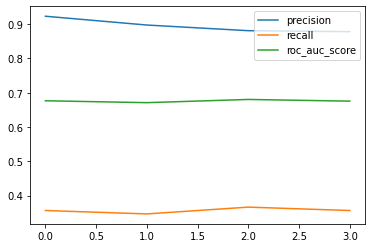

In [37]:
plt.plot(val_precision, label = 'precision')
plt.plot(val_recall, label = 'recall')
plt.plot(val_roc_auc_score, label = 'roc_auc_score')
plt.legend()

Text(0, 0.5, 'ROC')

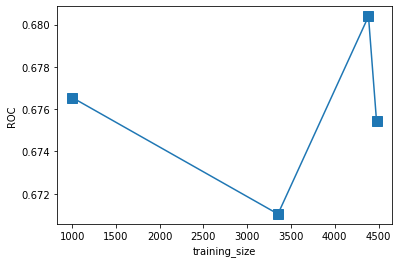

In [38]:
plt.plot(size_training, val_roc_auc_score, marker='s', markersize = 10)
plt.xlabel('training_size')
plt.ylabel('ROC')

Text(0, 0.5, 'Precision')

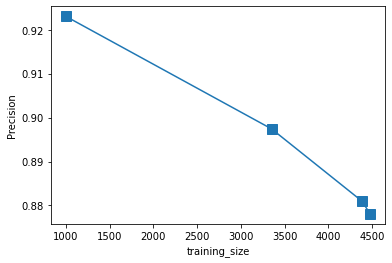

In [39]:
plt.plot(size_training, val_precision, marker='s', markersize = 10)
plt.xlabel('training_size')
plt.ylabel('Precision')

In [40]:
#precision went down because you are adding training set data (size), but not quality of training set.

Text(0, 0.5, 'Recall')

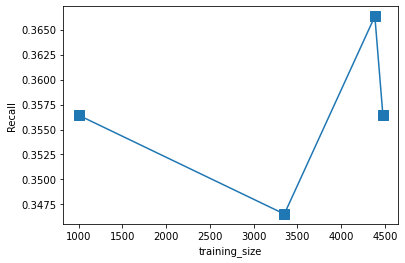

In [41]:
plt.plot(size_training, val_recall, marker='s', markersize = 10)
plt.xlabel('training_size')
plt.ylabel('Recall')

# Trying hyperparam tuning

In [42]:
#Gridsearch CV for hyperparameter tuning
# no need for scaler = StandardScaler() as we are alr using selectK

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [44]:
def grid_search_model(X_train,y_train,vectorizer): 
    pipeline = Pipeline([('vect', vectorizer),
                         ('chi',  SelectKBest(chi2)),
                         ('clf', RandomForestClassifier())])
    param_grid = {
    "chi__k": [400, 800, 1200, 1600],
    "clf__max_depth": [50, 100],}
    search = GridSearchCV(pipeline, param_grid,cv= 5, n_jobs=2)
    model = search.fit(X_train, y_train)
    return model
    
#training model only fit the model once
#training 40 models, 4x2x5 (5 for the folds)


In [45]:
def training_process_grid_search(cleaned):
    vectorized = vectorized_data(cleaned)
    vectorizer = vectorized
    X_train, y_train = define_x_y(cleaned)
    return grid_search_model(X_train,y_train,vectorizer)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

size_new_labels = 51

cleaned = cleaning_data(df_train_labelled)
cleaned_val = cleaning_data(df_validation_labelled)
# you have to clean also the comment_text in unlabelled data
cleaned_unlabelled = cleaning_data(df_test_sample)

val_precision = []
val_recall = []
val_roc_auc_score = []
min_new_labels = 50
size_training = []
X_val, y_val = define_x_y(cleaned_val)

while size_new_labels > min_new_labels:
    print(len(cleaned))
    trained_model = training_process_grid_search(cleaned)
    print("Best parameter (CV score=%0.3f):" % trained_model.best_score_)
    print(trained_model.best_params_)
    X_train,y_train = define_x_y(cleaned) 
    #print('train\nprecision, recall, roc_auc_score ')
    p,r,roc = train_val_scores(X_train,y_train, trained_model)
    #print('val\nprecision, recall, roc_auc_score ')
    p,r,roc = train_val_scores(X_val, y_val, trained_model)
    val_precision.append(p)
    val_recall.append(r)
    val_roc_auc_score.append(roc)  
    #the dataframes on the left are outputs of the function pseudo_label_creation 
    pseudo_label_df, cleaned_unlabelled = pseudo_label_creation(trained_model,cleaned_unlabelled)
    #print('new_pseudo_labels')
    size_new_labels = len(pseudo_label_df)
    print(size_new_labels)
    size_training.append(len(cleaned))
    
    if size_new_labels > min_new_labels:
        cleaned = cleaned.append(pseudo_label_df[['comment_text_cleaned', 'toxic']], ignore_index = True)

1000
Best parameter (CV score=0.918):
{'chi__k': 400, 'clf__max_depth': 100}
3152
4152
Best parameter (CV score=0.983):
{'chi__k': 800, 'clf__max_depth': 50}
347
4499


In [ ]:
plt.plot(val_precision, label = 'precision')
plt.plot(val_recall, label = 'recall')
plt.plot(val_roc_auc_score, label = 'roc_auc_score')
plt.legend()

In [ ]:
plt.plot(size_training, val_roc_auc_score, marker='s', markersize = 10)
plt.xlabel('training_size')
plt.ylabel('ROC')

In [ ]:
plt.plot(size_training, val_precision, marker='s', markersize = 10)
plt.xlabel('training_size')
plt.ylabel('Precision')

In [ ]:
#precision went down because you are adding training set data (size), but not quality of training set.

In [ ]:
plt.plot(size_training, val_recall, marker='s', markersize = 10)
plt.xlabel('training_size')
plt.ylabel('Recall')